# Redes Neuronales
## Preparacion de datos para el modelo

In [2]:
#Primero separamos el dataset en train y test.
#Para eso debemos ordenar segun fecha, elegimos columna 'Opportunity_Created_Date'
#Por conveniencia codifico ahora a la columna Stage como 1 o 0 si es 'Closed Won' o 'Closed Lost'

import Utilidades as ut
import Modelos as md
import numpy as np
import pandas as pd


df_train = pd.read_pickle("Neuronales_train.pkl")
df_test = pd.read_pickle("Neuronales_validation.pkl")

x_train, y_train = ut.split_labels(df_train)
x_test, y_test = ut.split_labels(df_test)

#Convertimos las fechas a numeros (cantidad de dias transcurridos) y luego las normalizamos
x_train, x_test = ut.conversion_fechas(x_train, x_test)
x_train, x_test = ut.codificar_categoricas(x_train, y_train, x_test)
x_train, x_test = ut.normalizacion_numericas(x_train, x_test, modo='normalizacion')

x_train.head(3)

,Region,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Billing_Country,Account_Owner,Opportunity_Owner,...,Total_Product_Family_Region_Month_Change,Total_Products_Region_This_Week,Total_Products_Region_Last_Week,Total_Products_Region_Week_Change,Total_Products_Region_This_Month,Total_Products_Region_Last_Month,Total_Products_Region_Month_Change,Total_Products_Region_This_Quarter,Total_Products_Region_Last_Quarter,Total_Products_Region_Quarter_Change
0,-3.61,-2.05,-1.14,-0.89,-0.64,-2.08,-1.34,-2.5,-2.11,-1.85,...,-1.2,-1.24,-1.25,-1.3,-2.00,-2.01,-7.05,-2.27,-2.28,-17.51
1,-3.61,0.49,0.88,1.12,1.56,-2.08,-0.95,-2.5,-2.11,-1.85,...,-1.2,-1.24,-1.25,-1.3,-2.00,-2.01,-7.05,-2.27,-2.28,-17.51
2,-3.61,0.49,-1.14,1.12,-0.64,-2.08,-1.28,-2.5,-2.11,-1.85,...,-1.2,-1.21,-1.25,-1.3,-1.99,-2.01,-7.05,-2.27,-2.28,-17.51


## Creacion del modelo.

In [24]:
import keras
import tensorflow as tf
#from keras import backend
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
#from keras.regularizers import l1
#from keras.regularizers import l2
#from keras.regularizers import l1_l2


x_train_vector = ut.df_a_vector(x_train)
y_train_vector = ut.df_a_vector(y_train)
x_test_vector = ut.df_a_vector(x_test)
y_test_vector = ut.df_a_vector(y_test)

#input_dim = x_train.shape[1]
#
#alfa = 1e-3
#
#model = Sequential()
#model.add(Dense(64, input_dim=input_dim, activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(128, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
##model.add(Dropout(0.25))
##model.add(Dense(256, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='tanh'))
#model.add(Dropout(0.5))
#model.add(Dense(128, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(64, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='tanh'))
#model.add(Dropout(0.25))
#model.add(Dense(16, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dense(8, kernel_regularizer=l1(alfa), bias_regularizer=l1(alfa), activation='relu'))
#model.add(Dense(1, activation='tanh'))
#
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#
#backend.set_value(model.optimizer.learning_rate, 5e-4)

best_hparams = ut.hyperparams_from_json('Neuronales')
model = md.get_neural_network_model(best_hparams, x_train.shape[1])

epochs = 500
batch_size = 256


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Neuronales_Mejor_Modelo.hdf5", 
                                       monitor='val_loss', 
                                       verbose=0,
                                       save_best_only=True, 
                                       mode='min'),
    
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                     min_delta=0.01,
                                     mode='min',
                                     patience=10),
    #keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    #                                  mode='min',
    #                                  factor=0.8,
    #                                  patience=5,
    #                                  cooldown=0, 
    #                                  min_lr=1e-8)
]

fit_dict = {
    #'x' : x_train_vector,
    #'y' : y_train_vector,
    #'validation_data' : (x_test_vector, y_test_vector),
    #'epochs' : epochs,
    #'batch_size' : batch_size,
    #'verbose' : 1,
    #'callbacks' : my_callbacks
}

#history = model.fit(x_train_vector, 
#                    y_train_vector, 
#                    epochs=epochs, 
#                    batch_size=batch_size,
#                    verbose = 1,
#                    validation_data=(x_test_vector, y_test_vector),
#                    callbacks=my_callbacks)


history = model.fit(x_train_vector,
                    y_train_vector,
                    validation_data=(x_test_vector, y_test_vector),
                    **fit_dict)


373/373 [==============================] - 2s 5ms/step - loss: 158.8559 - val_loss: 157.8208


In [6]:
#model.save('Neuronales_7740.h5')

## Resultados

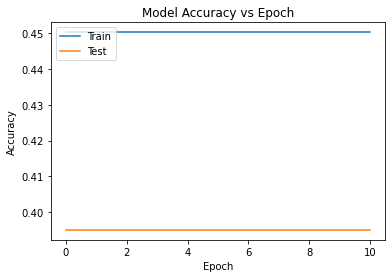

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
#new_model = keras.models.load_model('Neuronales_Mejor_Modelo.hdf5')
#new_predictions = new_model.predict(x_test)